In [17]:
from typing import Annotated
import os
from IPython.display import Image, display
from typing_extensions import TypedDict

from langchain_tavily import TavilySearch
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt

from dotenv import load_dotenv
load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "cathay-agent-club"
model_name = 'bedrock_converse:anthropic.claude-3-5-sonnet-20240620-v1:0'

In [18]:


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [19]:
llm = init_chat_model(model=model_name)
tools = [TavilySearch(max_results=2),
         human_assistance]
llm_with_tool = llm.bind_tools(tools)

In [20]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [21]:
def chatbot(state: State):
    messages = llm_with_tool.invoke(state["messages"])
    assert len(messages.tool_calls) <= 1
    
    return {"messages": [messages]}

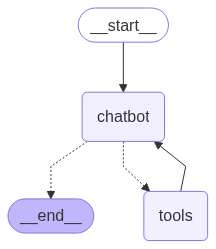

In [22]:
graph_builder = StateGraph(state_schema=State)
tool_node = ToolNode(tools)
memory = InMemorySaver()

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
user_input = "我需要一些專家的指導來建立一個 AI agent。你可以幫我請求協助嗎？"
config = {"configurable": {"thread_id": "1"}}


for chunk in graph.stream(State(messages=[user_input]), stream_mode="updates", config=config):
    print(chunk)
    print("\n")

{'chatbot': {'messages': [AIMessage(content=[{'type': 'text', 'text': '當然可以幫您請求專家協助來建立 AI agent。我會使用 human_assistance 工具來提出這個請求。讓我為您發送這個請求。'}, {'type': 'tool_use', 'name': 'human_assistance', 'input': {'query': '我需要一些專家指導來建立一個 AI agent。您能提供一些建議或資源嗎？具體來說，我想了解以下幾點：\n1. 開始建立 AI agent 的最佳實踐\n2. 常見的陷阱和如何避免\n3. 推薦的工具或框架\n4. 對於初學者的學習資源\n\n非常感謝您的協助！'}, 'id': 'tooluse_Joy7B8U1SACWJEL73FD_8Q'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '136f7ff2-1fe2-4e15-bb2e-b856b87b5905', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 01 Aug 2025 17:59:23 GMT', 'content-type': 'application/json', 'content-length': '750', 'connection': 'keep-alive', 'x-amzn-requestid': '136f7ff2-1fe2-4e15-bb2e-b856b87b5905'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [4563]}, 'model_name': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run--bafff32e-b08c-4b0d-ab4d-f35f50c3d226-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': '我需要一些專家指導來建立一個 

In [25]:
human_command = Command(resume={"data": "我們這些專家隨時準備提供協助！我們建議你試試 LangGraph 來建立你的 AI agent。它比簡單的自動化 agent 更加可靠且具擴充性。"})

In [26]:
for chunk in graph.stream(human_command, stream_mode="updates", config=config):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='我們這些專家隨時準備提供協助！我們建議你試試 LangGraph 來建立你的 AI agent。它比簡單的自動化 agent 更加可靠且具擴充性。', name='human_assistance', id='70c4ff87-5ed0-46f3-85b5-829263f60d2a', tool_call_id='tooluse_Joy7B8U1SACWJEL73FD_8Q')]}}


{'chatbot': {'messages': [AIMessage(content='非常感謝您的耐心等待。我已經收到了專家的回覆，他們提供了一些有價值的建議。以下是專家的回應：\n\n專家建議您嘗試使用 LangGraph 來建立您的 AI agent。他們指出，LangGraph 比簡單的自動化 agent 更加可靠且具有擴展性。\n\n基於這個建議，我可以為您提供一些額外的信息和建議：\n\n1. 開始建立 AI agent 的最佳實踐：\n   - 從了解 LangGraph 開始，這是一個專為建立複雜 AI agent 設計的框架。\n   - 在開始編碼之前，先仔細規劃您的 agent 的功能和結構。\n   - 從小規模開始，然後逐步擴展功能。\n\n2. 常見的陷阱和如何避免：\n   - 不要過度複雜化您的初始設計。從基本功能開始，然後逐步增加複雜性。\n   - 確保充分測試您的 agent，特別是在處理異常情況時。\n   - 注意 AI 倫理和隱私問題，確保您的 agent 符合相關法規和最佳實踐。\n\n3. 推薦的工具或框架：\n   - LangGraph：專家特別推薦的框架。\n   - 可能還需要考慮其他輔助工具，如用於自然語言處理的庫（例如 NLTK 或 spaCy）。\n\n4. 對於初學者的學習資源：\n   - 查找 LangGraph 的官方文檔和教程。\n   - 尋找有關 AI agent 開發的在線課程或工作坊。\n   - 參與相關的開發者社區，如 GitHub 或 Stack Overflow 上的 LangGraph 社區。\n\n如果您需要更多具體的指導或有任何特定問題，請隨時告訴我。我可以幫您進一步詢問專家或搜索更多相關信息。',

In [28]:
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------
